In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

# 如果用新既tfrecords，raw_image_dataset要改翻

In [2]:
displayFuncTime=1
orgSize = [512,512]
processedSize = [224,224]
#raw_image_dataset = tf.data.TFRecordDataset('video091810021016_512.tfrecords')
raw_image_dataset = tf.data.TFRecordDataset('TFrecord/trainval.tfrecords')
#dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dp = 0.2
EPOCHS = 13
learning_rate = 1e-3
Mname = "043_mobileNETv2_dp2_e50_vMarcoTrainVal02052021_unAUG_bce_lr0001"

In [3]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255
    input_mask += 0
    print("normalize function input_mask:",input_mask)
    return input_image, input_mask

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    #'label': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'segmentation_mask': tf.io.FixedLenFeature([], tf.string),
    'file_name': tf.io.FixedLenFeature([], tf.string),
}

@tf.function
def load_image_train(datapoint):
    datapoint = tf.io.parse_single_example(datapoint, image_feature_description)
    print("load_image_train's datapoint",datapoint['image'])
    height = tf.cast(datapoint['height'], tf.int64)
    width = tf.cast(datapoint['width'], tf.int64)
    depth = tf.cast(datapoint['depth'], tf.int64)
    image = tf.io.decode_raw(datapoint['image'], tf.uint8)
    segmentation_mask = tf.io.decode_raw(datapoint['segmentation_mask'], tf.uint8)
    image = tf.reshape(image, [height,width,depth])
    segmentation_mask = tf.reshape(segmentation_mask, [height,width,1])
    print('image:',image)
    #_parsed['image'] = image
    #_parsed['segmentation_mask'] = segmentation_mask
    input_image = tf.image.resize(image, (processedSize[0], processedSize[1]))
    print("load_image_train's input_image",input_image)
    input_mask = tf.image.resize(segmentation_mask, (processedSize[0], processedSize[1]))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    datapoint = tf.io.parse_single_example(datapoint, image_feature_description)
    print("load_image_test's datapoint",datapoint['image'])
    height = tf.cast(datapoint['height'], tf.int64)
    width = tf.cast(datapoint['width'], tf.int64)
    depth = tf.cast(datapoint['depth'], tf.int64)
    image = tf.io.decode_raw(datapoint['image'], tf.uint8)
    segmentation_mask = tf.io.decode_raw(datapoint['segmentation_mask'], tf.uint8)
    image = tf.reshape(image, [height,width,depth])
    segmentation_mask = tf.reshape(segmentation_mask, [height,width,1])
    print('image:',image)
    #_parsed['image'] = image
    #_parsed['segmentation_mask'] = segmentation_mask
    input_image = tf.image.resize(image, (processedSize[0], processedSize[1]))
    print("load_image_test's input_image",input_image)
    input_mask = tf.image.resize(segmentation_mask, (processedSize[0], processedSize[1]))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

####################Define loss#####################
from tensorflow.keras.losses import binary_crossentropy
smooth = 1e-15


def dice_coef(y_true, y_pred):
    def create_mask(pred_mask):
     pred_mask = tf.argmax(pred_mask, axis=-1)
     pred_mask = pred_mask[..., tf.newaxis]
     return pred_mask
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = create_mask(y_pred)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred)

In [4]:
TRAIN_LENGTH =  sum(1 for _ in raw_image_dataset)

#train_size = int(0.8 * TRAIN_LENGTH)
#test_size = TRAIN_LENGTH - train_size
BATCH_SIZE = 1
BUFFER_SIZE = 50
test_size = 862
train_size = 4024

print("train_size:{}, test_size:{}".format(train_size,test_size))

raw_image_dataset = raw_image_dataset.shuffle(BUFFER_SIZE)

train_dataset = raw_image_dataset.take(train_size)
test_dataset = raw_image_dataset.skip(train_size)

STEPS_PER_EPOCH = train_size // BATCH_SIZE

train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)



train_size:4024, test_size:862
load_image_train's datapoint Tensor("ParseSingleExample/ParseExample/ParseExampleV2:3", shape=(), dtype=string)
image: Tensor("Reshape:0", shape=(None, None, None), dtype=uint8)
load_image_train's input_image Tensor("resize/Squeeze:0", shape=(224, 224, None), dtype=float32)
normalize function input_mask: Tensor("add:0", shape=(224, 224, 1), dtype=float32)
load_image_test's datapoint Tensor("ParseSingleExample/ParseExample/ParseExampleV2:3", shape=(), dtype=string)
image: Tensor("Reshape:0", shape=(None, None, None), dtype=uint8)
load_image_test's input_image Tensor("resize/Squeeze:0", shape=(224, 224, None), dtype=float32)
normalize function input_mask: Tensor("add:0", shape=(224, 224, 1), dtype=float32)


sample_mask: tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(224, 224, 1), dtype=float32)


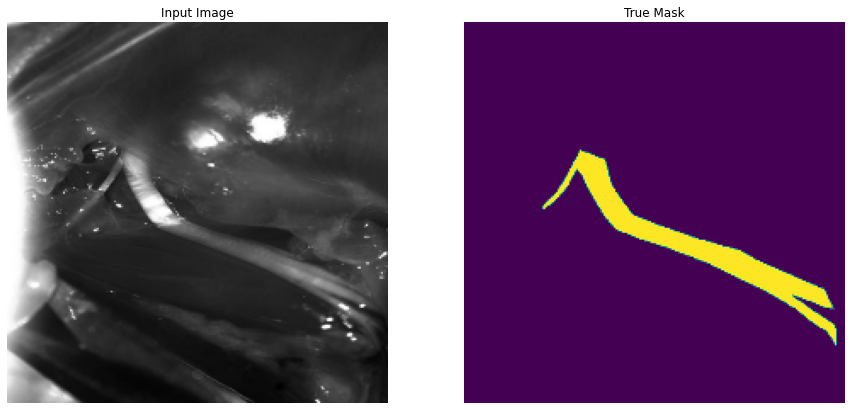

In [5]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    #print("raw {} display list {}".format(i,display_list[i]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def displayAndSave(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print("raw {} display list {}".format(i,display_list[i]))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    global displayFuncTime
    plt.savefig("display-{}".format(displayFuncTime))
    displayFuncTime+=1
    plt.show()


for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
print("sample_mask:",sample_mask)
display([sample_image, sample_mask])

# base_model有兩個選擇，一係load keras啲pretrained model，好似第一句咁；或者好似第二句咁load自己train既model

In [6]:
OUTPUT_CHANNELS = 2

#load keras啲pretrained model
base_model = tf.keras.applications.MobileNetV2(input_shape=[processedSize[0], processedSize[1], 3], include_top=False)
#base_model = tf.keras.applications.DenseNet169(input_shape=[processedSize[0], processedSize[1], 3], include_top=False)
#base_model = tf.keras.applications.DenseNet201(input_shape=[processedSize[0], processedSize[1], 3], include_top=False)
#base_model = tf.keras.applications.ResNet101V2(input_shape=[processedSize[0], processedSize[1], 3], include_top=False)
#load自己train既model
#base_model = tf.keras.models.load_model('saved_model/3-classes-model-94perc')
#base_model = tf.keras.models.load_model('saved_model/mobileNETv2_009')
#base_model.summary()
base_model.summary()


                                                    

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

# 呢度留意!!! layer_names係指揀base_model入面邊幾個layer做skip connection。如果你唔係用mobilenet就一定要改。但係要改做邊層Layer，老實講我都唔知。可以係上面既base_model.summary搵啲Layer 名黎試!!!

In [7]:

# Use the activations of these layers
#mobileNETv2
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
#denseNET169
#layer_names = [
    #'conv1/relu',   # 64x64
    #'conv2_block1_1_relu',   # 32x32
    #'conv3_block3_0_relu',   # 16x16
    #'conv4_block11_0_relu',  # 8x8
    #'conv5_block11_0_relu',      # 4x4
#]
#denseNET201
#layer_names = [
    #'conv1/relu',   # 64x64
    #'conv2_block1_1_relu',   # 32x32
    #'conv3_block3_0_relu',   # 16x16
    #'conv4_block11_0_relu',  # 8x8
    #'conv5_block3_0_relu',      # 4x4
#]
#resnet101V2
#layer_names = [
    #'conv1_conv',   # 64x64
    #'conv2_block1_1_relu',   # 32x32
    #'conv3_block1_1_relu',   # 16x16
    #'conv4_block1_preact_relu',  # 8x8
    #'conv5_block1_preact_relu',      # 4x4
#]

layers = [base_model.get_layer(name).output for name in layer_names] #pretrained mobileNET
#layers = [base_model.layers[3].get_layer(name).output for name in layer_names] #load mobileNET

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers) #pretrained mobileNET
#down_stack = tf.keras.Model(inputs=base_model.layers[3].input, outputs=layers) #load mobileNET

down_stack.trainable = False

In [8]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]


def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[processedSize[0], processedSize[1], 3])
  #x = data_augmentation(inputs)

  

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Dropout(dp)(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
#model.compile(loss=bce_dice_loss, optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])
tf.keras.utils.plot_model(model, show_shapes=True)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


iou value (sample pic): 0.055153877


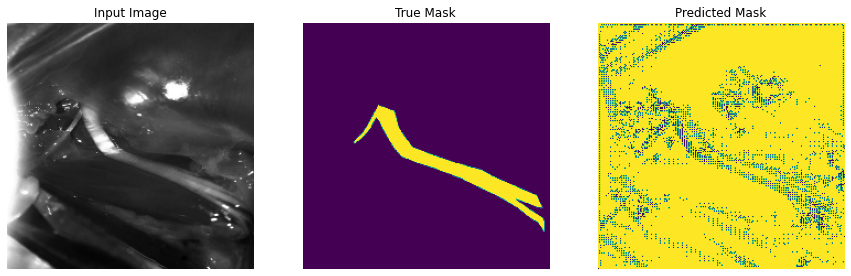

In [9]:
iouHistory = []

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


def show_predictions(dataset=None, num=1,recordValue=False):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        m = tf.keras.metrics.MeanIoU(num_classes=2)
        m.update_state(sample_mask, create_mask(pred_mask))
        print("iou value (sample pic):",m.result().numpy())
        if recordValue:
            displayAndSave([sample_image, sample_mask,create_mask(pred_mask)])
            iouHistory.append(m.result().numpy())
        else:
            display([sample_image, sample_mask,create_mask(pred_mask)])

            

show_predictions()


iou value (sample pic): 0.8641317


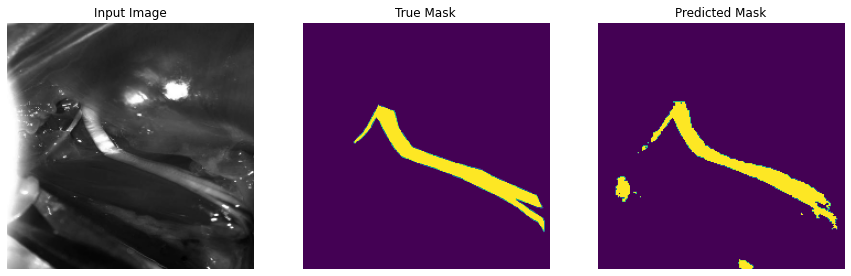


Sample Prediction after epoch 2

4024/4024 [==============================] - 697s 173ms/step - loss: 0.0423 - accuracy: 0.9814 - val_loss: 0.0445 - val_accuracy: 0.9809
Epoch 3/13
   5/4024 [..............................] - ETA: 8:57 - loss: 0.0584 - accuracy: 0.9731

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(None,1,True)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

##EPOCHS = 50 moved to the beginning
#VAL_SUBSPLITS = 1.25
VALIDATION_STEPS = test_size//BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()],
                         )

loss: [1.3196758031845093, 1.2704070806503296, 1.283452033996582, 1.273361325263977, 1.2597755193710327, 1.259971261024475, 1.2244443893432617, 1.2122071981430054, 1.20197594165802, 1.198186993598938, 1.1870356798171997, 1.1639792919158936, 1.1836504936218262]


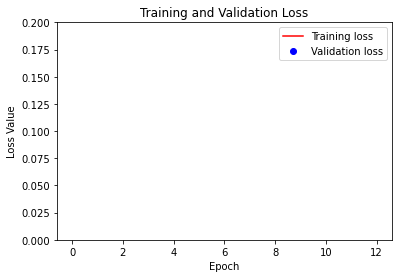

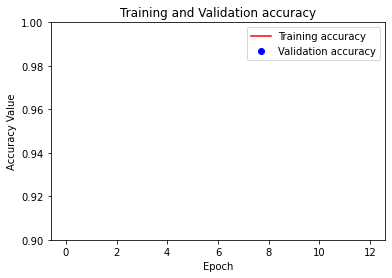

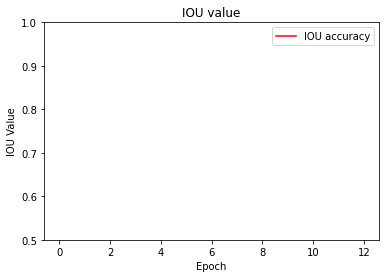

In [11]:
loss = model_history.history['loss']
print("loss:",loss)
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.2])
plt.legend()
#plt.show()
plt.savefig("results/"+Mname+"/loss.png")

##################################################

loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training accuracy')
plt.plot(epochs, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.ylim([0.9, 1])
plt.legend()
#plt.show()
plt.savefig("results/"+Mname+"/accuracy.png")

#####################################################
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, iouHistory, 'r', label='IOU accuracy')
plt.title('IOU value')
plt.xlabel('Epoch')
plt.ylabel('IOU Value')
plt.ylim([0.5, 1])
plt.legend()
#plt.show()
plt.savefig("results/"+Mname+"/IOU.png")

In [12]:
model.save('saved_model/'+Mname)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: saved_model/041_mobileNETv2_dp2_e13_v091810021016_bceDice_lr0001\assets


In [13]:
model = tf.keras.models.load_model('saved_model/'+Mname)


ValueError: Unknown loss function: bce_dice_loss

In [14]:
import numpy as np, scipy.stats as st

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255
    input_mask += 0
    print("normalize function input_mask:",input_mask)
    return input_image, input_mask

image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    #'label': tf.io.FixedLenFeature([], tf.int64),
    'image': tf.io.FixedLenFeature([], tf.string),
    'segmentation_mask': tf.io.FixedLenFeature([], tf.string),
    'file_name': tf.io.FixedLenFeature([], tf.string),
}
smooth = 1e-15
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

@tf.function
def load_image_train(datapoint):
    datapoint = tf.io.parse_single_example(datapoint, image_feature_description)
    print("load_image_train's datapoint",datapoint['image'])
    height = tf.cast(datapoint['height'], tf.int64)
    width = tf.cast(datapoint['width'], tf.int64)
    depth = tf.cast(datapoint['depth'], tf.int64)
    image = tf.io.decode_raw(datapoint['image'], tf.uint8)
    segmentation_mask = tf.io.decode_raw(datapoint['segmentation_mask'], tf.uint8)
    image = tf.reshape(image, [height,width,depth])
    segmentation_mask = tf.reshape(segmentation_mask, [height,width,1])
    print('image:',image)
    #_parsed['image'] = image
    #_parsed['segmentation_mask'] = segmentation_mask
    input_image = image
    #input_image = tf.image.resize(image, (processedSize[0], processedSize[1]))
    print("load_image_train's input_image",input_image)
    input_mask = segmentation_mask
    #input_mask = tf.image.resize(segmentation_mask, (processedSize[0], processedSize[1]))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    datapoint = tf.io.parse_single_example(datapoint, image_feature_description)
    print("load_image_test's datapoint",datapoint['image'])
    height = tf.cast(datapoint['height'], tf.int64)
    width = tf.cast(datapoint['width'], tf.int64)
    depth = tf.cast(datapoint['depth'], tf.int64)
    image = tf.io.decode_raw(datapoint['image'], tf.uint8)
    segmentation_mask = tf.io.decode_raw(datapoint['segmentation_mask'], tf.uint8)
    image = tf.reshape(image, [height,width,depth])
    segmentation_mask = tf.reshape(segmentation_mask, [height,width,1])
    print('image:',image)
    #_parsed['image'] = image
    #_parsed['segmentation_mask'] = segmentation_mask
    input_image = tf.image.resize(image, (processedSize[0], processedSize[1]))
    print("load_image_test's input_image",input_image)
    input_mask = tf.image.resize(segmentation_mask, (processedSize[0], processedSize[1]))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask



###########


def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    #print("raw {} display list {}".format(i,display_list[i]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def displayAndSave(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print("raw {} display list {}".format(i,display_list[i]))
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    global displayFuncTime
    plt.savefig("display-{}".format(displayFuncTime))
    displayFuncTime+=1
    plt.show()


###############

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
####################

np.set_printoptions(threshold=np.inf)

smooth = 1e-15

def show_predictions3(dataset=None, num=1,recordValue=False):
    if dataset:
        loopNum = 0
        for image, mask in dataset.take(num):
            #loopNum+=1
            pred_mask = model.predict(image)
            for i in image:
                loopNum+=1
                _PIL1 = np.array (tf.keras.preprocessing.image.array_to_img(mask[0]))
                _PIL2 = np.array (tf.keras.preprocessing.image.array_to_img(create_mask(pred_mask)))
                remap1 =  np.interp(_PIL1, (0, 255), (0, 1))
                remap2 =  np.interp(_PIL2, (0, 255), (0, 1))
                plt.axis('off')
                imgplot = plt.imshow(remap1+remap2)
                display([image[0], mask[0], create_mask(pred_mask)])
                print(loopNum)
                print("iou value for new dataset:",iou(remap1,remap2).numpy())
                print("dice:",dice_coef(remap1,remap2).numpy())
                iouAry.append(iou(remap1,remap2).numpy())
                diceAry.append(dice_coef(remap1,remap2).numpy())
                
                
            
            
            #_NP_ADDED = np.array(_PIL1)+np.array(_PIL2)
            #print(" remap1:",  remap1)
            
            #display([image[0], mask[0], create_mask(_NP_ADDED)])
            
            
            
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        m = iou(sample_mask, create_mask(pred_mask))
        print("iou value (sample pic):",m.numpy())
        if recordValue:
            displayAndSave([sample_image, sample_mask,create_mask(pred_mask)])
            iouHistory.append(m)
        else:
            display([sample_image, sample_mask,create_mask(pred_mask)])

            
            
def show_predictions4(dataset=None, num=1,recordValue=False):
    if dataset:
        loopNum = 0
        for image, mask in dataset.take(num):
            loopNum+=1
            pred_mask = model.predict(image)
            _PIL1 = np.array( tf.keras.preprocessing.image.array_to_img(mask[0]))
            _PIL2 = np.array (tf.keras.preprocessing.image.array_to_img(create_mask(pred_mask)))
            remap1 =  np.interp(_PIL1, (0, 255), (0, 1))
            remap2 =  np.interp(_PIL2, (0, 255), (0, 1))
            #_NP_ADDED = np.array(_PIL1)+np.array(_PIL2)
            #print(" remap1:",  remap1)
            plt.axis('off')
            imgplot = plt.imshow(remap1+remap2)
            display([image[0], mask[0], create_mask(pred_mask)])
            #display([image[0], mask[0], create_mask(_NP_ADDED)])
            print(loopNum)
            print("iou value for new dataset:",iou(remap1,remap2).numpy())
            print("dice:",dice_coef(remap1,remap2).numpy())
            iouAry.append(iou(remap1,remap2).numpy())
            diceAry.append(dice_coef(remap1,remap2).numpy())
            
            
    else:
        pred_mask = model.predict(sample_image[tf.newaxis, ...])
        m = iou(sample_mask, create_mask(pred_mask))
        print("iou value (sample pic):",m.numpy())
        if recordValue:
            displayAndSave([sample_image, sample_mask,create_mask(pred_mask)])
            iouHistory.append(m)
        else:
            display([sample_image, sample_mask,create_mask(pred_mask)])
#####################################

import numpy as np, scipy.stats as st

####################################




In [1]:
iouAry=[]
diceAry=[]

test_dataset = test.batch(1)
show_predictions4(test_dataset, test_size)

m1 = np.mean(iouAry)
s1 = st.sem(iouAry)
s = st.t.interval(0.95, len(iouAry)-1, loc=np.mean(iouAry), scale=st.sem(iouAry))
m2 = np.mean(diceAry)
s2 = st.sem(diceAry)
d = st.t.interval(0.95, len(diceAry)-1, loc=np.mean(diceAry), scale=st.sem(diceAry))

print(m1)
print(s1)
print(s)


g = open("results/"+Mname+"/TrainValResult.txt", 'a')
print("evaluation result for Validation dataset, which has the size of {}:" .format(test_size), file=g)
print("mean IOU: {}" .format(m1), file=g)
print("Standard error of mean of IOU: {}" .format(s1), file=g)
print("95% confidence interval of IOU is: {}" .format(s), file=g)
print("mean dice: {}" .format(m2), file=g)
print("Standard error of mean of dice: {}" .format(s2), file=g)
print("95% confidence interval of dice is: {}" .format(d), file=g)
g.close()

NameError: name 'test' is not defined

In [2]:
iouAry = []
diceAry=[]
train_dataset = train.batch(1)
show_predictions4(train_dataset, train_size)


m1 = np.mean(iouAry)
s1 = st.sem(iouAry)
s = st.t.interval(0.95, len(iouAry)-1, loc=np.mean(iouAry), scale=st.sem(iouAry))
m2 = np.mean(diceAry)
s2 = st.sem(diceAry)
d = st.t.interval(0.95, len(diceAry)-1, loc=np.mean(diceAry), scale=st.sem(diceAry))

print(m1)
print(s1)
print(s)


g = open("results/"+Mname+"/TrainValResult.txt", 'a')
print("evaluation result for Training dataset, which has the size of {}:" .format(train_size), file=g)
print("mean IOU: {}" .format(m1), file=g)
print("Standard error of mean of IOU: {}" .format(s1), file=g)
print("95% confidence interval of IOU is: {}" .format(s), file=g)
print("mean dice: {}" .format(m2), file=g)
print("Standard error of mean of dice: {}" .format(s2), file=g)
print("95% confidence interval of dice is: {}" .format(d), file=g)
g.close()

NameError: name 'train' is not defined